# Introduction
Pipeline from the paper [Persistence diagrams as morphological signatures of cells: A method to measure and compare cells within a population](https://files.yossi.eu/manuscripts/2310.20644.pdf) by Yossi Bokor Bleile, Pooja Yadav, Patrice Koehl, and Florian Rehfeldt.

The following packages need to be installed: 
- [Correa](correa.yossi.eu)
- plotly
- pandas
- sklearn
- numpy
- matplotlib
- tifffile


We begin the analysis by obtaining a persistence diagram for each cell in the population, as a summary of the morophology of the cell.

Below is the anlysis for `X1`, which can be repeated for `Y1` by replacing `X1` with `Y1` as appropriate and the running the relevant cells again.


## Import modules

In [1]:
import os
import correa
import pandas
import tifffile
import plotly.express as px
import plotly.figure_factory as ff		
import plotly.io as pio
import plotly.graph_objects as go
from sklearn import manifold, cluster, decomposition, metrics, preprocessing
import numpy
import scipy.cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from matplotlib import pyplot as plt
import matplotlib
from scipy.spatial.distance import squareform
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

pio.renderers.default = "notebook" #set the renderer to browser

## Custom functions for the analysis

We next define some custom functions to make creating the dendrograms easier.


In [2]:
#set colours
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)
hex_list = []
for c in px.colors.qualitative.Set1:
	hex_list.append(rgb_to_hex(int(c.replace("rgb(","").replace(")","").split(",")[0]),int(c.replace("rgb(","").replace(")","").split(",")[1]), int(c.replace("rgb(","").replace(")","").split(",")[2])))
 
def plot_dendrogram(model, **kwargs):
	# Create linkage matrix and then plot the dendrogram
	# create the counts of samples under each node
	counts = numpy.zeros(model.children_.shape[0])
	n_samples = len(model.labels_)
	for i, merge in enumerate(model.children_):
		current_count = 0
		for child_idx in merge:
			if child_idx < n_samples:
				current_count += 1  # leaf node
			else:
				current_count += counts[child_idx - n_samples]
		counts[i] = current_count
	linkage_matrix = numpy.column_stack([model.children_, model.distances_, counts]).astype(float)
	# Plot the corresponding dendrogram
	plt.figure(figsize=(2000,2000))
	plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
	plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
	dendrogram(linkage_matrix, **kwargs)

def generate_rand_index(cluster_df : pandas.DataFrame, to_compare : list):
	r_ind = pandas.DataFrame(columns=to_compare, index=to_compare)
	for i in to_compare:
		for j in to_compare:
			r_ind.loc[j,i] = metrics.rand_score(cluster_df[i], cluster_df[j])
	return r_ind

def population_percentages(df : pandas.DataFrame, clustering : str):
	labels = [int(c) for c in df[clustering]]
	counts = [0 for i in range(max(labels)+1)]
	for l in labels:
		counts[l]+=1
	percentages = [c/len(labels) for c in counts]
	return percentages, counts

def analysis(dists : pandas.DataFrame, n_colours : int , cluster_numbers : list,  name : str,  dir : str, group = False, exclude : list = [], show2d = False, showElbow=False, colour_list=hex_list):
	#colour order is red, purple, blue, green
	if group == False:
		inds = dists.index
		dists = dists
		if len(exclude) != 0:
			print("Need to exclude: ", exclude)
			inds = []
			for f in dists.index:
				if f not in exclude:
					inds.append(f)
			dists = dists.loc[inds, inds]
			print("now dists has shape: ", dists.shape)
	else:
		inds = []
		for f in dists.index:
			if group in f and f not in exclude:
				inds.append(f)
		dists = dists.loc[inds, inds]
	df = pandas.DataFrame(index=inds)
	embed = manifold.MDS(3, dissimilarity='precomputed', random_state=1, normalized_stress="auto").fit_transform(dists.to_numpy())
	df["x"] = embed[:,0]
	df["y"] = embed[:,1]
	df["z"] = embed[:,2]
	silhouette_samples = []
	silhouette_score = []
	linkage_matrices = []
	avg = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=n_colours, linkage="average")
	avg = avg.fit(dists.to_numpy())
	dflt = "#000000"
	D_leaf_colors = {dists.index[i]: colour_list[avg.labels_[i]] for i in range(len(avg.labels_))}
	#Average
	for link in ["average", "complete", "single", "ward"]:
		linkage = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=link)
		linkage = linkage.fit(dists.to_numpy())
		counts = numpy.zeros(linkage.children_.shape[0])
		n_samples = len(linkage.labels_)
		for i, merge in enumerate(linkage.children_):
			current_count = 0
			for child_idx in merge:
				if child_idx < n_samples:
					current_count += 1  # leaf node
				else:	
					current_count += counts[child_idx - n_samples]
			counts[i] = current_count
		linkage_matrix = numpy.column_stack([linkage.children_, linkage.distances_, counts]).astype(float)
		linkage_matrices.append(linkage_matrix)
		# notes:
		# * rows in Z correspond to "inverted U" links that connect clusters
		# * rows are ordered by increasing distance
		# * if the colors of the connected clusters match, use that color for link
		link_cols = {}
		for i, i12 in enumerate(linkage_matrix[:,:2].astype(int)):
			c1, c2 = (link_cols[x] if x > len(linkage_matrix) else D_leaf_colors[dists.index[x]] for x in i12)
			if c1 == c2:
				link_cols[i+1+len(linkage_matrix)] = c1
			else:
				if i12[0] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[0]]]
				elif i12[1] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[1]]]
				else:
					link_cols[i+1+len(linkage_matrix)] = dflt
		# Dendrogram
		D = dendrogram(Z=linkage_matrix, labels=dists.index, color_threshold=None, no_labels=True, link_color_func=lambda x: link_cols[x])
		#plt.xlabel(name+" "+link)
		plt.yticks([])
		plt.savefig(dir+"/"+name.replace(" ","_")+"_"+link+"_dendrogram.png")
		plt.show()
	sse = []
	for link in ["average", "complete", "single", "ward"]:
		for k in cluster_numbers:
			linkage = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=k, linkage=link)
			linkage = linkage.fit(dists.to_numpy())
			labels = linkage.labels_
			labels = [str(c) for c in labels]
			df[link+str(k)] = labels
			sil_score = metrics.silhouette_score(dists, df[link+str(k)], metric="precomputed")
			silhouette_score.append(sil_score)
			sil_samps = metrics.silhouette_samples(dists, df[link+str(k)], metric="precomputed")
			silhouette_samples.append([sil_samps])
			fig = px.scatter(df, x='x', y='y',color=link+str(k), title=name+" ("+link+" "+str(k)+")", hover_data=[df.index], width=800, height=600, color_discrete_map={
                "0": hex_list[0], "1": hex_list[1],"2": hex_list[1],"2": hex_list[2], "3": hex_list[3]})
			fig.update_traces(marker={'size': 5})
			if show2d:
				fig.show()
			fig.write_image(dir+"/"+name.replace(" ","_")+"_"+link+str(k)+"_2D.png")
	if showElbow:
		plt.plot(cluster_numbers, sse)
		plt.title("Elbow Method")
		plt.xlabel("Number of Clusters")
		plt.xticks(cluster_numbers)
		plt.ylabel("SSE")
		plt.savefig(dir+"/"+name.replace(" ","_")+"_kmeans-elbow.png")
		fig.show()
	df.to_csv(dir+"/"+name.replace(" ","_")+"_df.csv")
	rand_ind_tables_latex = []
	percentages_dict = {}
	for k in cluster_numbers:
		rand_ind_tables_latex.append(generate_rand_index(df, ["average"+str(k), "complete"+str(k), "single"+str(k),"ward"+str(k)]).to_latex())
		print("cluster sizes and percentages are:")
		percentages_dict["average{}".format(k)], counts = population_percentages(df, "average"+str(k))
		print("average{}".format(k), counts, percentages_dict["average{}".format(k)])
		percentages_dict["complete{}".format(k)], counts = population_percentages(df, "complete"+str(k))
		print("complete{}".format(k), counts, percentages_dict["complete{}".format(k)])
		percentages_dict["single{}".format(k)], counts = population_percentages(df, "single"+str(k))
		print("single{}".format(k), counts, percentages_dict["single{}".format(k)])
		percentages_dict["ward{}".format(k)], counts = population_percentages(df, "ward"+str(k))
		print("ward{}".format(k), counts, percentages_dict["ward{}".format(k)])
		#percentages_dict["kmeans++{}".format(k)] = population_percentages(df, "kmeans++"+str(k))
		#print("kmeans++{}".format(k), percentages_dict["kmeans++{}".format(k)])
	return df, silhouette_score, silhouette_samples, rand_ind_tables_latex, percentages_dict, dists, linkage_matrices

def get_main_population(analysis, cluster : str, dists : pandas.DataFrame):
	main_id = analysis[4][cluster].index(max(analysis[4][cluster]))
	main_index= analysis[0].index[analysis[0][cluster] == str(main_id)]
	return dists.loc[main_index,main_index]

def purity(merges, clus : set, n_objs):
	dct = dict([(i, {i}) for i in range(n_objs)])
	for i, row in enumerate(merges, n_objs):
		dct[i] = dct[row[0]].union(dct[row[1]])
		del dct[row[0]]
		del dct[row[1]]
		for c in list(dct.values()):
			if clus.issubset(c):
				return c, (n_objs-len(c))/(n_objs-len(clus))


# Example Dataset

In [3]:
dataset = "X1+Y1" #select the dataset to analyse and the set the correct width and height of the images
if dataset == "X1":
	width=1500 #we need to set the largest width of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	height=1692 #we need to set the largest height of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	scale_factor = 0.3155
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "X2":
	width=1455
	height=1584
	scale_factor = 0.3155
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "X3":
	width=1919
	height=1467
	scale_factor = 0.3155
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "Y1":
	width=1226 #we need to set the largest width of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	height=1088 #we need to set the largest height of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	scale_factor = 0.1639
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "X1+Y1":
	width_X1 = 1500
	height_X1 = 1692
	scale_factor_X1 = 0.3155
	width_Y1 = 1226
	height_Y1 = 1088
	scale_factor_Y1 = 0.1639
	files_X1 = os.listdir("X1/cell/raw_images")
	files_Y1 = os.listdir("Y1/cell/raw_images")
	cell_names_X1 = ["X1_"+str(int(file[0:3])) for file in files_X1 if file.endswith('.tif')]
	cell_names_Y1 = ["Y1_"+str(int(file[0:3])) for file in files_Y1 if file.endswith('.tif')]
	files = []
	files.extend(files_X1)
	files.extend(files_Y1)
	cell_names = []
	cell_names.extend(cell_names_X1)
	cell_names.extend(cell_names_Y1)
else:
	raise ValueError("Dataset not supported")

n_cells = len(cell_names)


First, we will load the file containing the center of the nucleus for each cell.

Next, for each cell will caculate the persistence diagram using a radial function based at the center of the nucles. We do need to translate the center of the nucleus into the same frame as the contour is in. This is due to the way FilamentSensor extracts the contour of each cell in a directory. The appropriate `height` and `width` values can be found in the [FilamentSensor2](https://filament-sensor.de/) log file.

In [4]:
if dataset == "X1+Y1":
	centers_X1 = pandas.read_csv("X1/Nuc_Cm_X1.csv", index_col="filename") #Load the center of the nucleus, labled by the nucleus file name
	centers_Y1 = pandas.read_csv("Y1/Nuc_Cm_Y1.csv", index_col="filename") #Load the center of the nucleus, labled by the nucleus file name
else:
	centers = pandas.read_csv(dataset+"/Nuc_Cm_"+dataset+".csv", index_col="filename") #Load the center of the nucleus, labled by the nucleus file name

In [12]:
contours_scaled_by_area = [] #list of contours
contours_not_scaled_by_area = []

for name in cell_names[:1]:
	if dataset == "X1+Y1":
		if "X1_" in name:
			i = int(name.split("_")[1])
			ds = "X1"
			height = height_X1
			width = width_X1
			actin = tifffile.imread(ds+"/cell/raw_images/"+str("%03d" % i)+".tif") #we need to know the size of the original image to shift the center of the nucleus to the correct position
			height_diff = height - actin.shape[0]
			width_diff = width - actin.shape[1]	
			fa = [centers_X1.loc[i,"X_m"]+width_diff/2,centers_X1.loc[i,"Y_m"]+height_diff/2]
			scale_factor = scale_factor_X1
		elif "Y1_" in name:
			i = int(name.split("_")[1])
			ds = "Y1"
			height = height_Y1
			width = width_Y1
			actin = tifffile.imread(ds+"/cell/raw_images/"+str("%03d" % i)+".tif") #we need to know the size of the original image to shift the center of the nucleus to the correct position
			height_diff = height - actin.shape[0]
			width_diff = width - actin.shape[1]
			fa = [centers_Y1.loc[i,"X_m"]+width_diff/2,centers_Y1.loc[i,"Y_m"]+height_diff/2]
			scale_factor = scale_factor_Y1
		else:
			raise ValueError("Cell name not supported")
	else:
		i = name
		ds = dataset
		height = height
		width = width
		actin = tifffile.imread(ds+"/cell/raw_images/"+str("%03d" % i)+".tif") #we need to know the size of the original image to shift the center of the nucleus to the correct position
		height_diff = height - actin.shape[0]
		width_diff = width - actin.shape[1]
		fa = [centers.loc[i,"X_m"]+width_diff/2,centers.loc[i,"Y_m"]+height_diff/2]
	print("ds is {} with scale factor {}".format(ds, scale_factor))

	c_i = correa.create_polygon_focal_point(ds+"/cell/contours/"+str("%03d" % i)+"_contour.csv", fa, scale_by_area=True, convert_to_microns_factor=scale_factor)
	contours_scaled_by_area.append(c_i)
	c_i = correa.create_polygon_focal_point(ds+"/cell/contours/"+str("%03d" % i)+"_contour.csv", fa, scale_by_area=False, convert_to_microns_factor=scale_factor)
	contours_not_scaled_by_area.append(c_i)
 

ds is X1 with scale factor 0.3155
Number of points loaded: 1013
focal is (698.678, 816.662).
Number of points before cleaning: 1013

Initial number of points in polygon      : 1013
Number of points in polygon after cleanup: 444

build the polygon with 444 points
shifting has occured, center was selected as (698.678, 816.662).
scaleArea is called
scale is 0.153777
position[0] is -0.469587
position[1] is -2.67355
height is 2.71447
position[0] is -0.438973
position[1] is -2.64293
height is 2.67914
position[0] is -0.438973
position[1] is -2.61232
height is 2.64894
position[0] is -0.423666
position[1] is -2.59701
height is 2.63134
position[0] is -0.423666
position[1] is -2.5817
height is 2.61624
position[0] is -0.408359
position[1] is -2.5664
height is 2.59868
position[0] is -0.408359
position[1] is -2.55109
height is 2.58357
position[0] is -0.393052
position[1] is -2.53578
height is 2.56606
position[0] is -0.393052
position[1] is -2.52048
height is 2.55094
position[0] is -0.347131
position

area is called
vertex: (-9.67891, -55.1059)
vertex: (-9.04791, -54.4749)
vertex: (-9.04791, -53.8439)
vertex: (-8.73241, -53.5284)
vertex: (-8.73241, -53.2129)
vertex: (-8.41691, -52.8974)
vertex: (-8.41691, -52.5819)
vertex: (-8.10141, -52.2664)
vertex: (-8.10141, -51.9509)
vertex: (-7.15491, -51.0044)
vertex: (-6.83941, -51.0044)
vertex: (-6.52391, -50.6889)
vertex: (-6.20841, -50.6889)
vertex: (-5.89291, -50.3734)
vertex: (-4.63091, -50.3734)
vertex: (-4.31541, -50.6889)
vertex: (-3.99991, -50.6889)
vertex: (-3.68441, -51.0044)
vertex: (-3.36891, -51.0044)
vertex: (-2.42241, -51.9509)
vertex: (-2.42241, -52.2664)
vertex: (-2.10691, -52.5819)
vertex: (-2.10691, -52.8974)
vertex: (-1.47591, -53.5284)
vertex: (-0.213909, -53.5284)
vertex: (1.36359, -51.9509)
vertex: (1.67909, -51.9509)
vertex: (1.99459, -51.6354)
vertex: (2.31009, -51.6354)
vertex: (2.62559, -51.3199)
vertex: (2.94109, -51.3199)
vertex: (3.25659, -51.0044)
vertex: (3.25659, -50.6889)
vertex: (3.57209, -50.3734)
vertex:


position[1] is -0.760175
height is 0.945023
position[0] is -0.561429
position[1] is -0.989779
height is 1.13792
position[0] is -0.576736
position[1] is -1.00509
height is 1.1588
position[0] is -0.576736
position[1] is -1.05101
height is 1.19885
position[0] is -0.592043
position[1] is -1.06631
height is 1.21965
position[0] is -0.592043
position[1] is -1.20408
height is 1.34176
position[0] is -0.60735
position[1] is -1.21938
height is 1.36227
position[0] is -0.60735
position[1] is -1.31123
height is 1.44506
position[0] is -0.592043
position[1] is -1.32653
height is 1.45265
position[0] is -0.592043
position[1] is -1.54083
height is 1.65066
position[0] is -0.576736
position[1] is -1.55614
height is 1.65957
position[0] is -0.576736
position[1] is -1.6939
height is 1.78939
position[0] is -0.592043
position[1] is -1.70921
height is 1.80884
position[0] is -0.592043
position[1] is -1.83166
height is 1.92497
position[0] is -0.60735
position[1] is -1.84697
height is 1.94427
position[0] is -0.607

30.0741, 4.20814)
vertex: (30.0741, 5.15464)
vertex: (30.3896, 5.47014)
vertex: (30.3896, 8.94064)
vertex: (30.7051, 9.25614)
vertex: (30.7051, 12.4111)
vertex: (31.0206, 12.7266)
vertex: (31.0206, 13.6731)
vertex: (31.3361, 13.9886)
vertex: (31.3361, 14.9351)
vertex: (31.6516, 15.2506)
vertex: (31.6516, 16.1971)
vertex: (31.9671, 16.5126)
vertex: (31.9671, 16.8281)
vertex: (32.2826, 17.1436)
vertex: (32.2826, 17.7746)
vertex: (32.5981, 18.0901)
vertex: (32.5981, 19.6676)
vertex: (31.9671, 20.2986)
vertex: (31.9671, 20.6141)
vertex: (31.6516, 20.9296)
vertex: (31.6516, 21.2451)
vertex: (31.3361, 21.5606)
vertex: (31.3361, 22.1916)
vertex: (31.0206, 22.5071)
vertex: (31.0206, 22.8226)
vertex: (30.7051, 23.1381)
vertex: (30.7051, 26.2931)
vertex: (31.0206, 26.6086)
vertex: (31.0206, 27.8706)
vertex: (31.3361, 28.1861)
vertex: (31.3361, 30.3946)
vertex: (31.6516, 30.7101)
vertex: (31.6516, 32.2876)
vertex: (31.9671, 32.6031)
vertex: (31.9671, 33.5496)
vertex: (32.2826, 33.8651)
vertex: (3

35
position[1] is -1.89289
height is 1.98794
position[0] is -0.622657
position[1] is -1.9082
height is 2.00722
position[0] is -0.622657
position[1] is -2.01535
height is 2.10934
position[0] is -0.60735
position[1] is -2.03065
height is 2.11953
position[0] is -0.60735
position[1] is -2.1378
height is 2.2224
position[0] is -0.622657
position[1] is -2.15311
height is 2.24133
position[0] is -0.622657
position[1] is -2.24495
height is 2.3297
position[0] is -0.60735
position[1] is -2.26026
height is 2.34044
position[0] is -0.60735
position[1] is -2.36741
height is 2.44407
position[0] is -0.622657
position[1] is -2.38271
height is 2.46273
position[0] is -0.622657
position[1] is -2.44394
height is 2.52201
position[0] is -0.561429
position[1] is -2.50517
height is 2.56731
position[0] is -0.561429
position[1] is -2.52048
height is 2.58225
position[0] is -0.546122
position[1] is -2.53578
height is 2.59392
position[0] is -0.546122
position[1] is -2.55109
height is 2.60889
position[0] is -0.530815


21)
vertex: (-6.20841, 56.8966)
vertex: (-6.20841, 55.3191)
vertex: (-5.89291, 55.0036)
vertex: (-5.89291, 41.4371)
vertex: (-5.57741, 41.1216)
vertex: (-5.57741, 38.9131)
vertex: (-5.89291, 38.5976)
vertex: (-5.89291, 33.5496)
vertex: (-6.20841, 33.2341)
vertex: (-6.20841, 29.7636)
vertex: (-6.52391, 29.4481)
vertex: (-6.52391, 27.5551)
vertex: (-6.83941, 27.2396)
vertex: (-6.83941, 25.3466)
vertex: (-7.15491, 25.0311)
vertex: (-7.15491, 23.7691)
vertex: (-7.47041, 23.4536)
vertex: (-7.47041, 21.5606)
vertex: (-7.78591, 21.2451)
vertex: (-7.78591, 19.6676)
vertex: (-8.10141, 19.3521)
vertex: (-8.10141, 18.0901)
vertex: (-8.41691, 17.7746)
vertex: (-8.41691, 16.5126)
vertex: (-8.73241, 16.1971)
vertex: (-8.73241, 11.4646)
vertex: (-9.04791, 11.1491)
vertex: (-9.04791, 6.41664)
vertex: (-9.36341, 6.10114)
vertex: (-9.36341, 4.52364)
vertex: (-9.67891, 4.20814)
vertex: (-9.67891, 1.68414)
vertex: (-9.99441, 1.36864)
vertex: (-9.99441, -1.47086)
vertex: (-10.3099, -1.78636)
vertex: (-10.3

[1] is 6.40422
height is 11.9471
position[0] is 10.0856
position[1] is 6.50376
height is 12.0008
position[0] is 9.98608
position[1] is 6.6033
height is 11.9719
position[0] is 9.98608
position[1] is 6.70284
height is 12.027
position[0] is 9.88654
position[1] is 6.80238
height is 12.0007
position[0] is 9.88654
position[1] is 7.00146
height is 12.1146
position[0] is 9.787
position[1] is 7.101
height is 12.0917
position[0] is 9.787
position[1] is 7.20054
height is 12.1504
position[0] is 9.68746
position[1] is 7.30008
height is 12.13
position[0] is 9.68746
position[1] is 8.29549
height is 12.7539
position[0] is 9.787
position[1] is 8.39503
height is 12.8943
position[0] is 9.787
position[1] is 8.79319
height is 13.157
position[0] is 9.88654
position[1] is 8.89273
height is 13.2975
position[0] is 9.88654
position[1] is 9.58951
height is 13.7732
position[0] is 9.98608
position[1] is 9.68905
height is 13.914
position[0] is 9.98608
position[1] is 10.1868
height is 14.265
position[0] is 10.0856
p

7251)
vertex: (3.88759, 71.7251)
vertex: (3.57209, 71.4096)
vertex: (3.25659, 71.4096)
vertex: (2.94109, 71.0941)
vertex: (1.99459, 71.0941)
vertex: (-0.213909, 68.8856)
vertex: (-0.529409, 68.8856)
vertex: (-0.844909, 68.5701)
vertex: (-1.16041, 68.5701)
vertex: (-1.47591, 68.2546)
vertex: (-2.73791, 68.2546)
vertex: (-3.05341, 68.5701)
vertex: (-3.36891, 68.5701)
vertex: (-3.68441, 68.2546)
vertex: (-3.99991, 68.2546)
vertex: (-4.31541, 67.9391)
vertex: (-5.57741, 67.9391)
vertex: (-5.89291, 68.2546)
vertex: (-6.20841, 68.2546)
vertex: (-6.52391, 68.5701)
vertex: (-7.47041, 68.5701)
vertex: (-7.78591, 68.8856)
vertex: (-9.36341, 68.8856)
vertex: (-9.67891, 68.5701)
vertex: (-9.99441, 68.5701)
vertex: (-9.99441, 68.2546)
vertex: (-10.3099, 67.9391)
vertex: (-10.3099, 67.6236)
vertex: (-10.6254, 67.3081)
vertex: (-10.6254, 66.0461)
vertex: (-10.3099, 65.7306)
vertex: (-10.3099, 65.4151)
vertex: (-8.73241, 63.8376)
vertex: (-8.73241, 63.5221)
vertex: (-8.41691, 63.2066)
vertex: (-8.4169

In [13]:
cs = contours_scaled_by_area[0]
cn = contours_not_scaled_by_area[0]

In [33]:
cn.originalArea() == cs.originalArea()

True

In [34]:
cn.area()

area is called
vertex: (-3.0537, -17.3859)
vertex: (-2.85462, -17.1868)
vertex: (-2.85462, -16.9877)
vertex: (-2.75508, -16.8882)
vertex: (-2.75508, -16.7887)
vertex: (-2.65553, -16.6891)
vertex: (-2.65553, -16.5896)
vertex: (-2.55599, -16.49)
vertex: (-2.55599, -16.3905)
vertex: (-2.25737, -16.0919)
vertex: (-2.15783, -16.0919)
vertex: (-2.05829, -15.9923)
vertex: (-1.95875, -15.9923)
vertex: (-1.85921, -15.8928)
vertex: (-1.46105, -15.8928)
vertex: (-1.36151, -15.9923)
vertex: (-1.26197, -15.9923)
vertex: (-1.16243, -16.0919)
vertex: (-1.06289, -16.0919)
vertex: (-0.76427, -16.3905)
vertex: (-0.76427, -16.49)
vertex: (-0.66473, -16.5896)
vertex: (-0.66473, -16.6891)
vertex: (-0.465649, -16.8882)
vertex: (-0.0674883, -16.8882)
vertex: (0.430213, -16.3905)
vertex: (0.529753, -16.3905)
vertex: (0.629293, -16.291)
vertex: (0.728834, -16.291)
vertex: (0.828374, -16.1914)
vertex: (0.927914, -16.1914)
vertex: (1.02745, -16.0919)
vertex: (1.02745, -15.9923)
vertex: (1.12699, -15.8928)
vertex

5.948315784081266e+79

65854)
vertex: (-3.45186, -2.95256)
vertex: (-3.5514, -3.0521)
vertex: (-3.5514, -3.5498)
vertex: (-3.65094, -3.64934)
vertex: (-3.65094, -4.04751)
vertex: (-3.75048, -4.14705)
vertex: (-3.75048, -4.84383)
vertex: (-3.65094, -4.94337)
vertex: (-3.65094, -6.43647)
vertex: (-3.75048, -6.53601)
vertex: (-3.75048, -6.83463)
vertex: (-3.85002, -6.93417)
vertex: (-3.85002, -7.83004)
vertex: (-3.94956, -7.92958)
vertex: (-3.94956, -8.52682)
vertex: (-3.85002, -8.62636)
vertex: (-3.85002, -10.0199)
vertex: (-3.75048, -10.1195)
vertex: (-3.75048, -11.0153)
vertex: (-3.85002, -11.1149)
vertex: (-3.85002, -11.9112)
vertex: (-3.94956, -12.0107)
vertex: (-3.94956, -12.3093)
vertex: (-4.0491, -12.4089)
vertex: (-4.0491, -13.1057)
vertex: (-3.94956, -13.2052)
vertex: (-3.94956, -13.902)
vertex: (-4.0491, -14.0015)
vertex: (-4.0491, -14.5988)
vertex: (-3.94956, -14.6983)
vertex: (-3.94956, -15.3951)
vertex: (-4.0491, -15.4946)
vertex: (-4.0491, -15.8928)
vertex: (-3.65094, -16.291)
vertex: (-3.65094, 

In [35]:
cs.area()

area is called
vertex: (-0.469587, -2.67355)
vertex: (-0.438973, -2.64293)
vertex: (-0.438973, -2.61232)
vertex: (-0.423666, -2.59701)
vertex: (-0.423666, -2.5817)
vertex: (-0.408359, -2.5664)
vertex: (-0.408359, -2.55109)
vertex: (-0.393052, -2.53578)
vertex: (-0.393052, -2.52048)
vertex: (-0.347131, -2.47456)
vertex: (-0.331824, -2.47456)
vertex: (-0.316518, -2.45925)
vertex: (-0.301211, -2.45925)
vertex: (-0.285904, -2.44394)
vertex: (-0.224676, -2.44394)
vertex: (-0.209369, -2.45925)
vertex: (-0.194062, -2.45925)
vertex: (-0.178755, -2.47456)
vertex: (-0.163448, -2.47456)
vertex: (-0.117527, -2.52048)
vertex: (-0.117527, -2.53578)
vertex: (-0.10222, -2.55109)
vertex: (-0.10222, -2.5664)
vertex: (-0.071606, -2.59701)
vertex: (-0.0103781, -2.59701)
vertex: (0.0661567, -2.52048)
vertex: (0.0814637, -2.52048)
vertex: (0.0967707, -2.50517)
vertex: (0.112078, -2.50517)
vertex: (0.127385, -2.48986)
vertex: (0.142692, -2.48986)
vertex: (0.157999, -2.47456)
vertex: (0.157999, -2.45925)
vert

9.147122773559997e+78

We can also plot the contours and mark the center of the nucleus

In [ ]:
for i in cell_names: #cell number we want to look at
	contour = pandas.read_csv(dataset+"/cell/contours/"+str("%03d" % i)+"_contour.csv",header=None)
	actin = tifffile.imread(dataset+"/cell/raw_images/"+str("%03d" % i)+".tif")
	nucleus = tifffile.imread(dataset+"/nucleus/raw_images/"+str("%03d" % i)+".tif")
	height_diff = height - actin.shape[0]
	width_diff = width - actin.shape[1]
	center = pandas.DataFrame([[centers.loc[i,"X_m"]+width_diff/2,centers.loc[i,"Y_m"]+height_diff/2]], columns=["x", "y"])
	fig_data = px.scatter(contour, x=0, y=1, width=800, height=600).data
	fig_data = fig_data + px.scatter(center, x="x", y="y").update_traces(marker={'size': 5, 'color': 'Red'}).data
	fig = go.Figure(fig_data)
	fig.show()


Once we have a persistence diagram for each cell summarising its morphology, we compute the Wasserstein distance between each pair of persistence diagrams as a (dis)similarity score for each pair of cells.

In [38]:
w_distances_scaled_by_area = numpy.zeros((n_cells,n_cells))
w_distances_not_scaled_by_area = numpy.zeros((n_cells,n_cells))
for i in range(n_cells):
	for j in range(i,n_cells):
		dist = correa.wasserstein_distance(contours_scaled_by_area[i], contours_scaled_by_area[j], q=2)
		w_distances_scaled_by_area[i,j] = dist
		w_distances_scaled_by_area[j,i] = dist
		print("for scaled by area {} and {} dist is {}".format(i,j,dist))
		dist = correa.wasserstein_distance(contours_not_scaled_by_area[i], contours_not_scaled_by_area[j], q=2)
		w_distances_not_scaled_by_area[i,j] = dist
		w_distances_not_scaled_by_area[j,i] = dist
		print("for not scaled by area {} and {} dist is {}".format(i,j,dist))



for scaled by area 0 and 0 dist is 0.0
for not scaled by area 0 and 0 dist is 0.0
for scaled by area 0 and 1 dist is 3.3986057690824825
for not scaled by area 0 and 1 dist is 26.282699986156434
for scaled by area 0 and 2 dist is 7.603065396607319
for not scaled by area 0 and 2 dist is 50.76704791758477
for scaled by area 0 and 3 dist is 7.282292340830738
for not scaled by area 0 and 3 dist is 61.549002819602755
for scaled by area 0 and 4 dist is 1.3833413617388017
for not scaled by area 0 and 4 dist is 27.723624100179837
for scaled by area 0 and 5 dist is 6.010250642343434
for not scaled by area 0 and 5 dist is 34.76131876608075
for scaled by area 0 and 6 dist is 1.78533668528006
for not scaled by area 0 and 6 dist is 25.709678147931644
for scaled by area 0 and 7 dist is 1.6141220566417593
for not scaled by area 0 and 7 dist is 19.64465934917327
for scaled by area 0 and 8 dist is 3.229498529701949
for not scaled by area 0 and 8 dist is 24.338844716951364
for scaled by area 0 and 9 dist

In [39]:
px.imshow(w_distances_scaled_by_area,width=500, height=500).show()

In [41]:
px.imshow(w_distances_not_scaled_by_area,width=500, height=500).show()

In [42]:
dists_scaled_by_area = pandas.DataFrame(w_distances_scaled_by_area, columns=cell_names, index=cell_names)
dists_not_scaled_by_area = pandas.DataFrame(w_distances_not_scaled_by_area, columns=cell_names, index=cell_names)

In [51]:
dists_scaled_by_area.to_csv(dataset+"/distances_scaled_by_area.csv")
dists_not_scaled_by_area.to_csv(dataset+"/distances_not_scaled_by_area.csv")
dists_scaled_by_area.to_csv(dataset+"/distances_scaled_by_area.dat", header=False, index=False)
dists_not_scaled_by_area.to_csv(dataset+"/distances_not_scaled_by_area.dat", header=False, index=False)

/Users/yossi/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



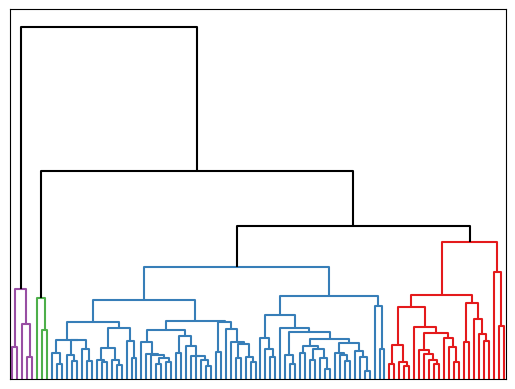

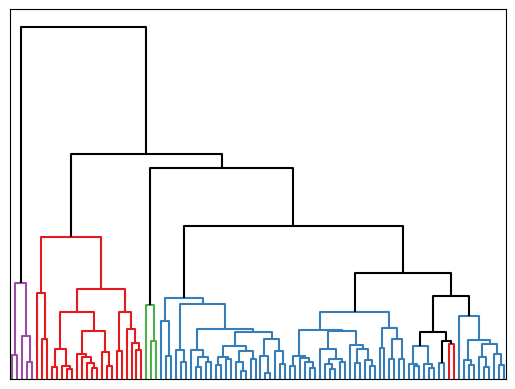

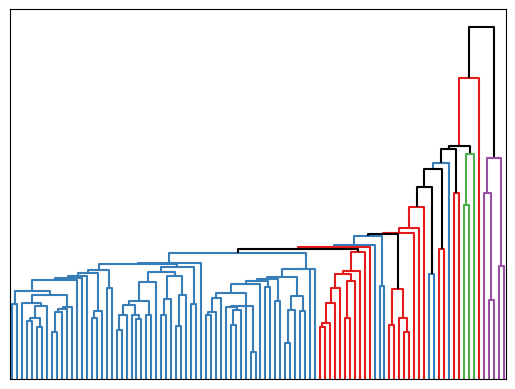

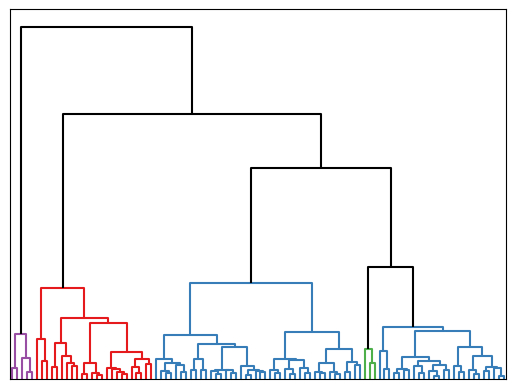

cluster sizes and percentages are:
average3 [92, 5, 3] [0.92, 0.05, 0.03]
complete3 [73, 5, 22] [0.73, 0.05, 0.22]
single3 [94, 5, 1] [0.94, 0.05, 0.01]
ward3 [71, 5, 24] [0.71, 0.05, 0.24]
cluster sizes and percentages are:
average4 [24, 68, 3, 5] [0.24, 0.68, 0.03, 0.05]
complete4 [70, 5, 22, 3] [0.7, 0.05, 0.22, 0.03]
single4 [91, 3, 1, 5] [0.91, 0.03, 0.01, 0.05]
ward4 [29, 42, 24, 5] [0.29, 0.42, 0.24, 0.05]
cluster sizes and percentages are:
average5 [68, 3, 3, 5, 21] [0.68, 0.03, 0.03, 0.05, 0.21]
complete5 [22, 5, 44, 3, 26] [0.22, 0.05, 0.44, 0.03, 0.26]
single5 [3, 5, 1, 2, 89] [0.03, 0.05, 0.01, 0.02, 0.89]
ward5 [42, 26, 24, 5, 3] [0.42, 0.26, 0.24, 0.05, 0.03]


/Users/yossi/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



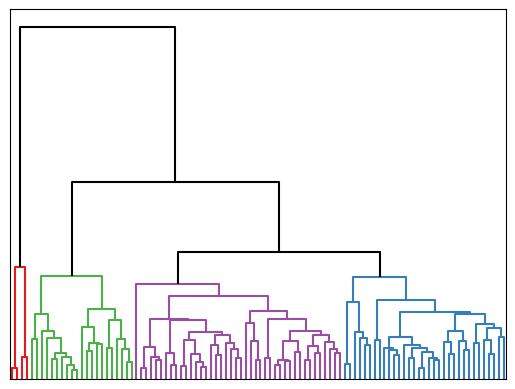

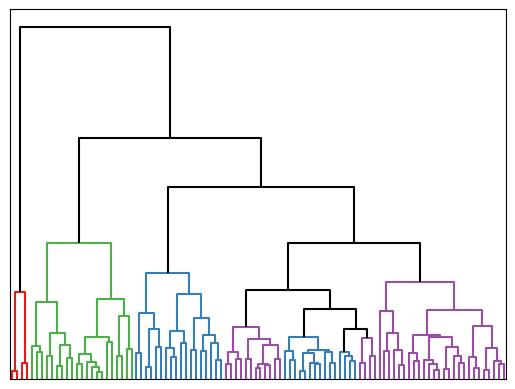

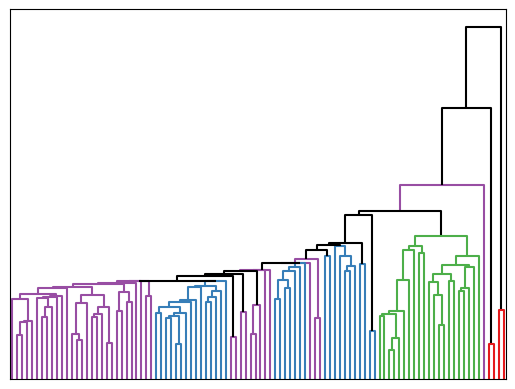

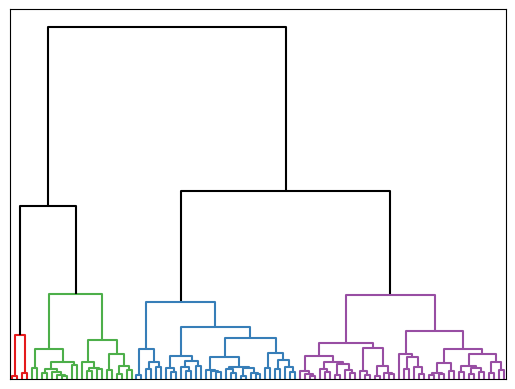

cluster sizes and percentages are:
average3 [75, 4, 21] [0.75, 0.04, 0.21]
complete3 [75, 4, 21] [0.75, 0.04, 0.21]
single3 [96, 2, 2] [0.96, 0.02, 0.02]
ward3 [25, 42, 33] [0.25, 0.42, 0.33]
cluster sizes and percentages are:
average4 [4, 33, 21, 42] [0.04, 0.33, 0.21, 0.42]
complete4 [21, 18, 57, 4] [0.21, 0.18, 0.57, 0.04]
single4 [95, 2, 2, 1] [0.95, 0.02, 0.02, 0.01]
ward4 [21, 42, 33, 4] [0.21, 0.42, 0.33, 0.04]
cluster sizes and percentages are:
average5 [21, 33, 2, 42, 2] [0.21, 0.33, 0.02, 0.42, 0.02]
complete5 [57, 18, 12, 4, 9] [0.57, 0.18, 0.12, 0.04, 0.09]
single5 [74, 21, 2, 1, 2] [0.74, 0.21, 0.02, 0.01, 0.02]
ward5 [42, 4, 33, 11, 10] [0.42, 0.04, 0.33, 0.11, 0.1]


In [173]:
# Filter for just X1 cells
# x1_cells = [name for name in cell_names if name.startswith('X1_')]
# dists_scaled_x1 = dists_scaled_by_area.loc[x1_cells, x1_cells]
# dists_not_scaled_x1 = dists_not_scaled_by_area.loc[x1_cells, x1_cells]

# # Save X1-only distance matrices
# dists_scaled_x1.to_csv(dataset+"/distances_scaled_by_area_X1.csv")
# dists_not_scaled_x1.to_csv(dataset+"/distances_not_scaled_by_area_X1.csv")
# dists_scaled_x1.to_csv(dataset+"/distances_scaled_by_area_X1.dat", header=False, index=False)
# dists_not_scaled_x1.to_csv(dataset+"/distances_not_scaled_by_area_X1.dat", header=False, index=False)

# # Run analysis on X1-only matrices
# A_scaled_x1 = analysis(dists_scaled_x1, 4, [3,4,5], "Scaled X1", "X1")
# A_not_scaled_x1 = analysis(dists_not_scaled_x1, 4, [3,4,5], "Not Scaled X1", "X1")


# Filter for just X1 cells
y1_cells = [name for name in cell_names if name.startswith('Y1_')]
dists_scaled_y1 = dists_scaled_by_area.loc[y1_cells, y1_cells]
dists_not_scaled_y1 = dists_not_scaled_by_area.loc[y1_cells, y1_cells]

# Save X1-only distance matrices
dists_scaled_y1.to_csv(dataset+"/distances_scaled_by_area_Y1.csv")
dists_not_scaled_y1.to_csv(dataset+"/distances_not_scaled_by_area_Y1.csv")
dists_scaled_y1.to_csv(dataset+"/distances_scaled_by_area_Y1.dat", header=False, index=False)
dists_not_scaled_y1.to_csv(dataset+"/distances_not_scaled_by_area_Y1.dat", header=False, index=False)

# Run analysis on X1-only matrices
A_scaled_y1 = analysis(dists_scaled_y1, 4, [3,4,5], "Scaled Y1", "Y1")
A_not_scaled_y1 = analysis(dists_not_scaled_y1, 4, [3,4,5], "Not Scaled Y1", "Y1")


/Users/yossi/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



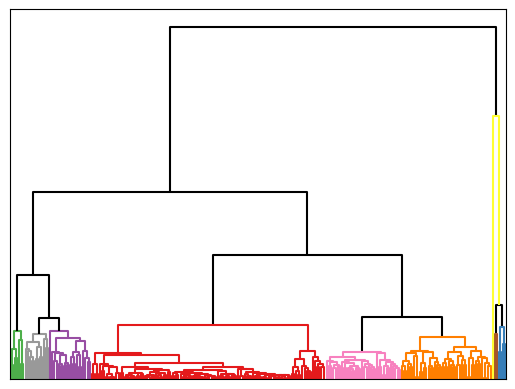

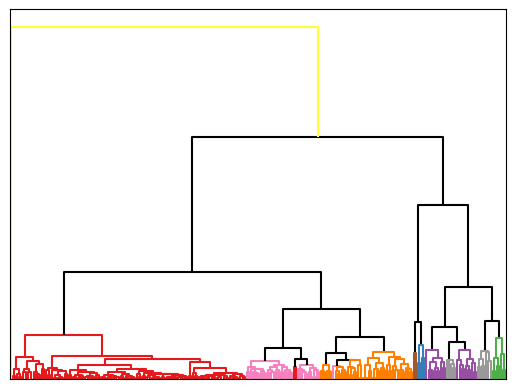

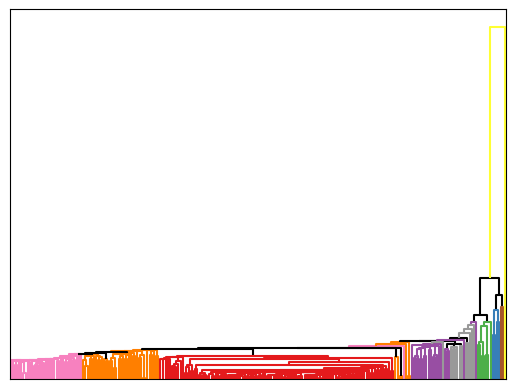

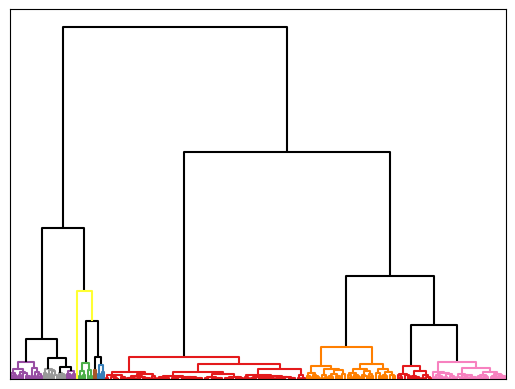

cluster sizes and percentages are:
average3 [233, 6, 1] [0.9708333333333333, 0.025, 0.004166666666666667]
complete3 [45, 1, 194] [0.1875, 0.004166666666666667, 0.8083333333333333]
single3 [6, 1, 233] [0.025, 0.004166666666666667, 0.9708333333333333]
ward3 [46, 97, 97] [0.19166666666666668, 0.4041666666666667, 0.4041666666666667]
cluster sizes and percentages are:
average4 [194, 39, 1, 6] [0.8083333333333333, 0.1625, 0.004166666666666667, 0.025]
complete4 [194, 6, 39, 1] [0.8083333333333333, 0.025, 0.1625, 0.004166666666666667]
single4 [2, 4, 233, 1] [0.008333333333333333, 0.016666666666666666, 0.9708333333333333, 0.004166666666666667]
ward4 [97, 14, 97, 32] [0.4041666666666667, 0.058333333333333334, 0.4041666666666667, 0.13333333333333333]
cluster sizes and percentages are:
average5 [39, 6, 1, 80, 114] [0.1625, 0.025, 0.004166666666666667, 0.3333333333333333, 0.475]
complete5 [39, 6, 81, 1, 113] [0.1625, 0.025, 0.3375, 0.004166666666666667, 0.4708333333333333]
single5 [4, 1, 233, 1, 1]

/Users/yossi/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



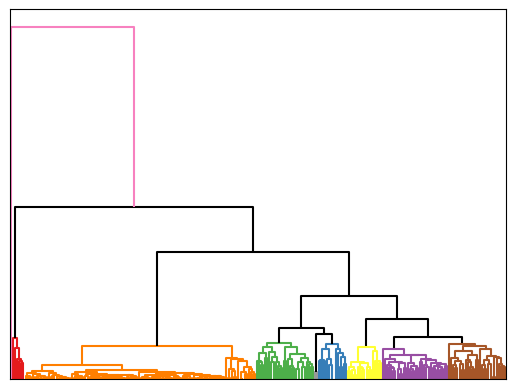

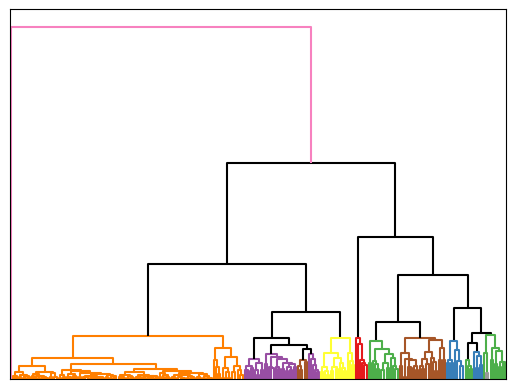

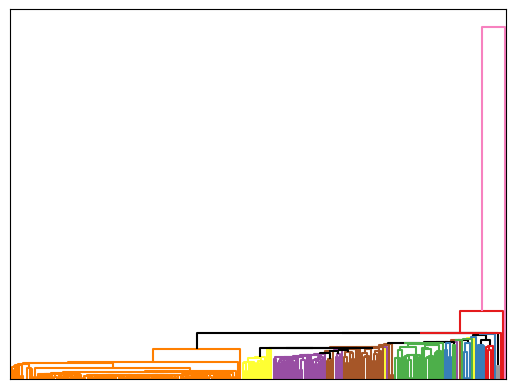

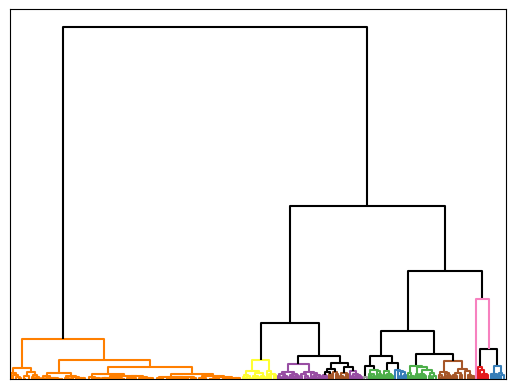

cluster sizes and percentages are:
average3 [233, 1, 6] [0.9708333333333333, 0.004166666666666667, 0.025]
complete3 [73, 1, 166] [0.30416666666666664, 0.004166666666666667, 0.6916666666666667]
single3 [238, 1, 1] [0.9916666666666667, 0.004166666666666667, 0.004166666666666667]
ward3 [69, 112, 59] [0.2875, 0.4666666666666667, 0.24583333333333332]
cluster sizes and percentages are:
average4 [121, 112, 6, 1] [0.5041666666666667, 0.4666666666666667, 0.025, 0.004166666666666667]
complete4 [166, 6, 67, 1] [0.6916666666666667, 0.025, 0.2791666666666667, 0.004166666666666667]
single4 [237, 1, 1, 1] [0.9875, 0.004166666666666667, 0.004166666666666667, 0.004166666666666667]
ward4 [15, 54, 59, 112] [0.0625, 0.225, 0.24583333333333332, 0.4666666666666667]
cluster sizes and percentages are:
average5 [77, 44, 6, 1, 112] [0.32083333333333336, 0.18333333333333332, 0.025, 0.004166666666666667, 0.4666666666666667]
complete5 [67, 112, 54, 1, 6] [0.2791666666666667, 0.4666666666666667, 0.225, 0.0041666666

In [55]:
A_scaled = analysis(dists_scaled_by_area, 9, [3,4,5,6,7,8,9,10], "Scaled "+dataset, dataset)
A_not_scaled = analysis(dists_not_scaled_by_area, 9, [3,4,5,6,7,8,9,10], "Not Scaled "+dataset, dataset)

In [45]:
# Check purity of not scaled clusters in scaled merge tree
print("Checking purity of not scaled clusters in scaled merge tree:")

methods = ["average", "complete", "single", "ward"]
k_values = [3,4,5,6,7,8,9,10]

n_cells = len(A_scaled[0])

for k in k_values:
	for method in methods:
		print(f"\nFor k={k} with linkage {method}:")
		not_scaled_clusters = A_scaled[0][f"{method}{k}"]
		
		# For each cluster in not scaled clustering
		for cluster_id in set(not_scaled_clusters):
			# Get indices of cells in this cluster
			clust = set()
			for i in range(len(not_scaled_clusters)):
				if not_scaled_clusters.iloc[i] == cluster_id:
					clust.add(i)
					
			# Calculate purity in scaled merge trees
			print(f"\nCluster {cluster_id} size {len(clust)}:")
			print(f"Average: {purity(A_scaled[6][0], clust, n_cells)[1]:.2%}")
			print(f"Complete: {purity(A_scaled[6][1], clust, n_cells)[1]:.2%}")
			print(f"Single: {purity(A_scaled[6][2], clust, n_cells)[1]:.2%}")
			print(f"Ward: {purity(A_scaled[6][3], clust, n_cells)[1]:.2%}")


Checking purity of not scaled clusters in scaled merge tree:

For k=3 with linkage average:

Cluster 2 size 1:
Average: 100.00%
Complete: 100.00%
Single: 100.00%
Ward: 100.00%

Cluster 1 size 6:
Average: 100.00%
Complete: 100.00%
Single: 100.00%
Ward: 100.00%

Cluster 0 size 233:
Average: 100.00%
Complete: 14.29%
Single: 100.00%
Ward: 0.00%

For k=3 with linkage complete:

Cluster 2 size 194:
Average: 100.00%
Complete: 100.00%
Single: 100.00%
Ward: 100.00%

Cluster 1 size 1:
Average: 100.00%
Complete: 100.00%
Single: 100.00%
Ward: 100.00%

Cluster 0 size 45:
Average: 0.00%
Complete: 100.00%
Single: 0.51%
Ward: 99.49%

For k=3 with linkage single:

Cluster 2 size 233:
Average: 100.00%
Complete: 14.29%
Single: 100.00%
Ward: 0.00%

Cluster 1 size 1:
Average: 100.00%
Complete: 100.00%
Single: 100.00%
Ward: 100.00%

Cluster 0 size 6:
Average: 100.00%
Complete: 100.00%
Single: 100.00%
Ward: 100.00%

For k=3 with linkage ward:

Cluster 2 size 97:
Average: 100.00%
Complete: 100.00%
Single: 96.

In [177]:
# Plot MDS coordinates colored by dataset using plotly express
import plotly.express as px
import pandas as pd
# Create interactive scatter plot
fig = px.scatter(A_scaled[0], x='x', y='y', color='dataset',
                 title='MDS Coordinates Colored by Dataset',
                 labels={'MDS1': 'MDS1', 'MDS2': 'MDS2', 'MDS3': 'MDS3'}, hover_data=[A_scaled[0].index]).update_traces(marker={'size': 5})
fig.show()
fig.write_html("X1+Y1_scaled_dataset_mds.html")
fig.write_image("X1+Y1_scaled_dataset_mds.png")



In [175]:
mds_coords = A_not_scaled[0]

# Create dataframe with MDS coordinates and dataset labels
df_plot = pd.DataFrame({
    'MDS1': mds_coords['x'],
    'MDS2': mds_coords['y'],
	'MDS3': mds_coords['z'],
    'dataset': ['X1' if cell_name.startswith('X1') else 'Y1' for cell_name in A_scaled[0].index]
})

# Create interactive scatter plot
fig = px.scatter(df_plot, x='MDS1', y='MDS2', color='dataset',
                 title='MDS Coordinates Colored by Dataset',
                 labels={'MDS1': 'MDS1', 'MDS2': 'MDS2', 'MDS3': 'MDS3'}, hover_data=[A_scaled[0].index]).update_traces(marker={'size': 5})
fig.show()
fig.write_html("X1+Y1_not_scaled_dataset_mds.html")
fig.write_image("X1+Y1_not_scaled_dataset_mds.png")




In `X1`, the heatmap and all 4 dendrograms indicate there is an outlier, so lets identify which cell this is. Using `average4` the outlier has cluster number 3.

In [25]:
if dataset == "X1":
	for i in A_scaled[0].index:
		if int(A_scaled[0].loc[i]["average4"]) == 3:
			print("Scaled {}".format(i))
	for i in A_not_scaled[0].index:
		if int(A_not_scaled[0].loc[i]["average4"]) == 3:
			print("Not Scaled {}".format(i))

Scaled 15
Not Scaled 15


In [26]:
print("SCALED:")
n_c = A_scaled[0].shape[0]
print(n_c)
for k in range(5):
	clus = set(())
	for i in range(len(A_scaled[0]["average5"])):
		if A_scaled[0]["average5"].iloc[i] == str(k):
			clus.add(i)
	print("cluster "+str(k)+" with size "+str(len(clus)))
	print("average: "+str(purity(A_scaled[6][0], clus, n_c)[1]))
	print("complete: "+str(purity(A_scaled[6][1], clus, n_c)[1]))
	print("single: "+str(purity(A_scaled[6][2], clus, n_c)[1]))
	print("ward: "+str(purity(A_scaled[6][3], clus, n_c)[1]))

print("\nNOT SCALED:")
n_c = A_not_scaled[0].shape[0]
print(n_c)
for k in range(5):
	clus = set(())
	for i in range(len(A_not_scaled[0]["average5"])):
		if A_not_scaled[0]["average5"].iloc[i] == str(k):
			clus.add(i)
	print("cluster "+str(k)+" with size "+str(len(clus)))
	print("average: "+str(purity(A_not_scaled[6][0], clus, n_c)[1]))
	print("complete: "+str(purity(A_not_scaled[6][1], clus, n_c)[1]))
	print("single: "+str(purity(A_not_scaled[6][2], clus, n_c)[1]))
	print("ward: "+str(purity(A_not_scaled[6][3], clus, n_c)[1]))

SCALED:
140
cluster 0 with size 6
average: 1.0
complete: 1.0
single: 1.0
ward: 1.0
cluster 1 with size 95
average: 1.0
complete: 0.8666666666666667
single: 1.0
ward: 1.0
cluster 2 with size 10
average: 1.0
complete: 1.0
single: 0.05384615384615385
ward: 0.0
cluster 3 with size 1
average: 1.0
complete: 1.0
single: 1.0
ward: 1.0
cluster 4 with size 28
average: 1.0
complete: 0.0625
single: 0.14285714285714285
ward: 0.9732142857142857

NOT SCALED:
140
cluster 0 with size 86
average: 1.0
complete: 0.3333333333333333
single: 0.07407407407407407
ward: 1.0
cluster 1 with size 22
average: 1.0
complete: 0.00847457627118644
single: 0.025423728813559324
ward: 1.0
cluster 2 with size 7
average: 1.0
complete: 0.924812030075188
single: 0.007518796992481203
ward: 1.0
cluster 3 with size 1
average: 1.0
complete: 1.0
single: 1.0
ward: 1.0
cluster 4 with size 24
average: 1.0
complete: 1.0
single: 1.0
ward: 1.0


In [65]:
if dataset == "X1+Y1":
    # Check each cluster in average5 clustering
    for k in range(10):
        clus = []
        # Get all points in this cluster
        for i in range(len(A_scaled[0]["average10"])):
            if A_scaled[0]["average10"].iloc[i] == str(k):
                clus.append(A_scaled[0].index[i])
        # Check if all points start with Y1_
        all_Y1 = all(point.startswith('Y1_') for point in clus)
        
        if all_Y1:
            print(f"Cluster {k} contains only Y1 points:")
            print(clus)
            print(f"Size: {len(clus)}")


If desired we can use the `analysis` command with the `exclude` parameter to exclude cell a from our analysis.

Need to exclude:  ['X1_15']
now dists has shape:  (139, 139)


/Users/yossi/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



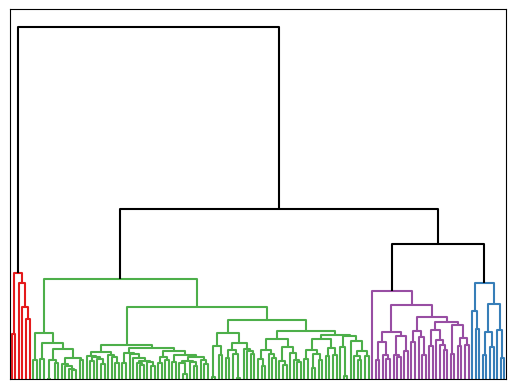

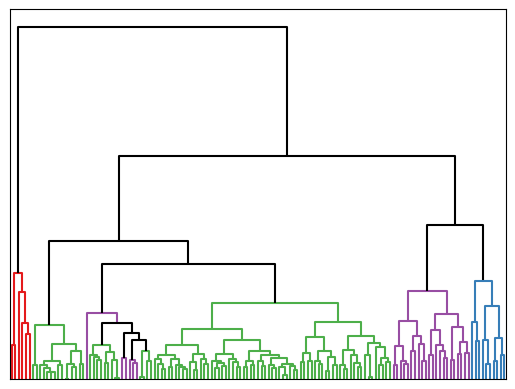

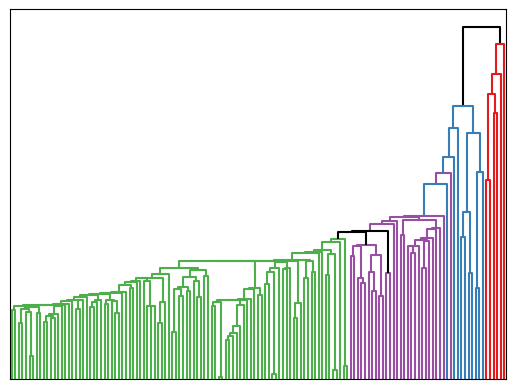

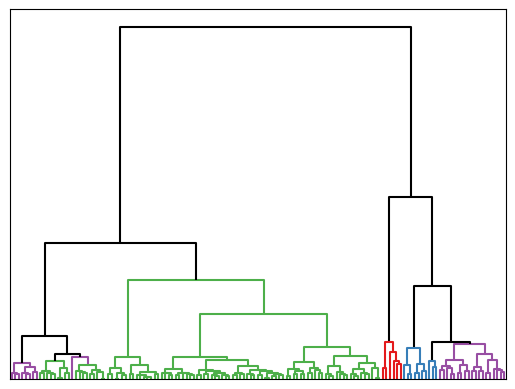

cluster sizes and percentages are:
average3 [38, 6, 95] [0.2733812949640288, 0.04316546762589928, 0.6834532374100719]
complete3 [32, 6, 101] [0.2302158273381295, 0.04316546762589928, 0.7266187050359713]
single3 [5, 133, 1] [0.03597122302158273, 0.9568345323741008, 0.007194244604316547]
ward3 [104, 29, 6] [0.7482014388489209, 0.20863309352517986, 0.04316546762589928]
cluster sizes and percentages are:
average4 [6, 10, 95, 28] [0.04316546762589928, 0.07194244604316546, 0.6834532374100719, 0.2014388489208633]
complete4 [101, 6, 10, 22] [0.7266187050359713, 0.04316546762589928, 0.07194244604316546, 0.15827338129496402]
single4 [4, 133, 1, 1] [0.02877697841726619, 0.9568345323741008, 0.007194244604316547, 0.007194244604316547]
ward4 [77, 29, 6, 27] [0.5539568345323741, 0.20863309352517986, 0.04316546762589928, 0.19424460431654678]
cluster sizes and percentages are:
average5 [95, 10, 4, 28, 2] [0.6834532374100719, 0.07194244604316546, 0.02877697841726619, 0.2014388489208633, 0.01438848920863

/Users/yossi/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



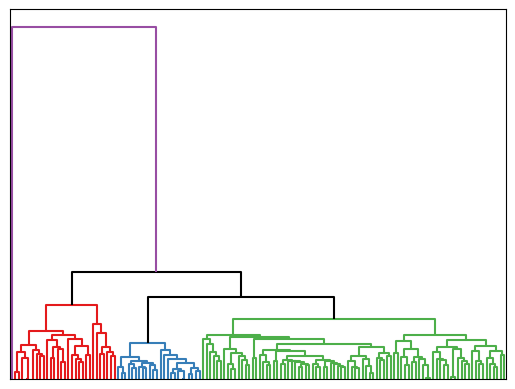

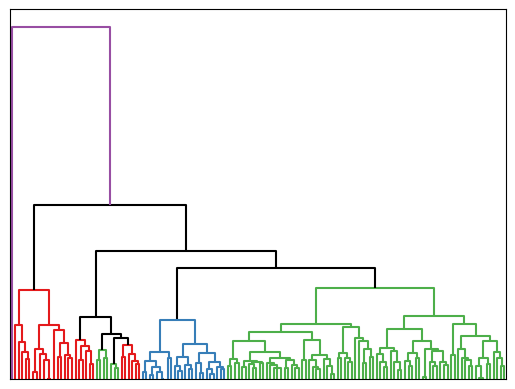

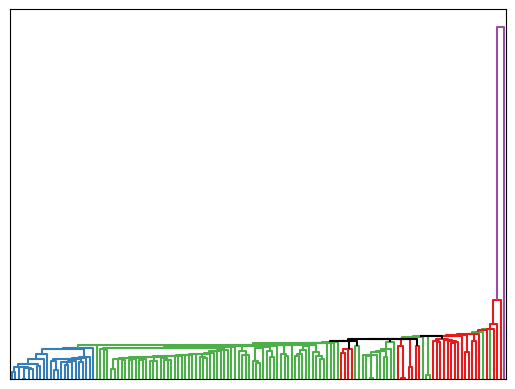

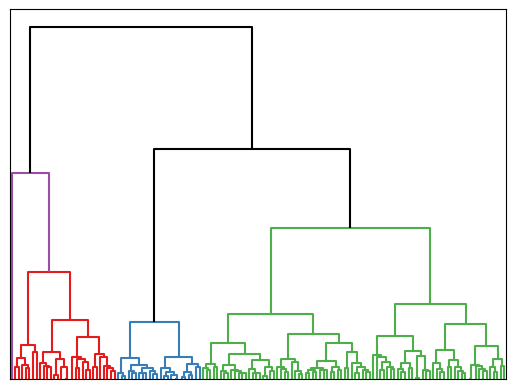

cluster sizes and percentages are:
average3 [110, 1, 29] [0.7857142857142857, 0.007142857142857143, 0.20714285714285716]
complete3 [122, 1, 17] [0.8714285714285714, 0.007142857142857143, 0.12142857142857143]
single3 [138, 1, 1] [0.9857142857142858, 0.007142857142857143, 0.007142857142857143]
ward3 [30, 86, 24] [0.21428571428571427, 0.6142857142857143, 0.17142857142857143]
cluster sizes and percentages are:
average4 [29, 24, 86, 1] [0.20714285714285716, 0.17142857142857143, 0.6142857142857143, 0.007142857142857143]
complete4 [103, 19, 17, 1] [0.7357142857142858, 0.1357142857142857, 0.12142857142857143, 0.007142857142857143]
single4 [137, 1, 1, 1] [0.9785714285714285, 0.007142857142857143, 0.007142857142857143, 0.007142857142857143]
ward4 [86, 29, 24, 1] [0.6142857142857143, 0.20714285714285716, 0.17142857142857143, 0.007142857142857143]
cluster sizes and percentages are:
average5 [86, 22, 7, 1, 24] [0.6142857142857143, 0.15714285714285714, 0.05, 0.007142857142857143, 0.17142857142857143

NameError: name 'X1_main' is not defined

In [119]:
# if dataset == "X1":
A_main_scaled = analysis(dists_scaled_x1, n_colours=4, cluster_numbers=[3,4,5], name="X1 main", dir =dataset, exclude=["X1_15"])
A_main_not_scaled = analysis(dists_not_scaled_x1, n_colours=4, cluster_numbers=[3,4,5], name="X1 main", dir=dataset, exclude=["X1_015"])


In [123]:
n_c = A_main_not_scaled[0].shape[0]
print(n_c)
for k in range(4):
	clus = set(())
	for i in range(len(A_main_not_scaled[0]["average4"])):
		if A_main_not_scaled[0]["average4"].iloc[i] == str(k):
			clus.add(i)
	print("not scaled cluster "+str(k)+" with size "+str(len(clus)))
	print("average: "+str(purity(A_main_not_scaled[6][0], clus, n_c)[1]))
	print("complete: "+str(purity(A_main_not_scaled[6][1], clus, n_c)[1]))
	print("single: "+str(purity(A_main_not_scaled[6][2], clus, n_c)[1]))
	print("ward: "+str(purity(A_main_not_scaled[6][3], clus, n_c)[1]))

n_c = A_main_scaled[0].shape[0]
print(n_c)
for k in range(4):
	clus = set(())
	for i in range(len(A_main_scaled[0]["average4"])):
		if A_main_scaled[0]["average4"].iloc[i] == str(k):
			clus.add(i)
	print("scaled cluster "+str(k)+" with size "+str(len(clus)))
	print("average: "+str(purity(A_main_scaled[6][0], clus, n_c)[1]))
	print("complete: "+str(purity(A_main_scaled[6][1], clus, n_c)[1]))
	print("single: "+str(purity(A_main_scaled[6][2], clus, n_c)[1]))
	print("ward: "+str(purity(A_main_scaled[6][3], clus, n_c)[1]))

140
not scaled cluster 0 with size 29
average: 1.0
complete: 0.009009009009009009
single: 0.009009009009009009
ward: 1.0
not scaled cluster 1 with size 24
average: 1.0
complete: 1.0
single: 1.0
ward: 1.0
not scaled cluster 2 with size 86
average: 1.0
complete: 0.3333333333333333
single: 0.07407407407407407
ward: 1.0
not scaled cluster 3 with size 1
average: 1.0
complete: 1.0
single: 1.0
ward: 1.0
139
scaled cluster 0 with size 6
average: 1.0
complete: 1.0
single: 1.0
ward: 1.0
scaled cluster 1 with size 10
average: 1.0
complete: 1.0
single: 0.046511627906976744
ward: 0.8527131782945736
scaled cluster 2 with size 95
average: 1.0
complete: 0.8636363636363636
single: 1.0
ward: 0.7954545454545454
scaled cluster 3 with size 28
average: 1.0
complete: 0.05405405405405406
single: 0.13513513513513514
ward: 0.0


In [143]:
for i in range(len(A_main_scaled[0]["average4"])):
	if A_main_scaled[0]["average4"].iloc[i] == str(0):
		print(A_main_scaled[0].index[i]
)


X1_72
X1_66
X1_9
X1_52
X1_96
X1_120


In [160]:
# A_scaled[0]["dataset"] = ["X1" if cell_name.startswith('X1') else 'Y1' for cell_name in A_scaled[0].index]

px.scatter(A_scaled[0], x="x", y="y", color="average4",  hover_data=[A_scaled[0].index], width=800, height=600).show()

In [163]:
# A_not_scaled[0]["dataset"] = ["X1" if cell_name.startswith('X1') else 'Y1' for cell_name in A_not_scaled[0].index]
px.scatter(A_not_scaled[0], x="x", y="y", color="ward9",  hover_data=[A_not_scaled[0].index], width=800, height=600).show()


In [171]:
print(dists_not_scaled_by_area.loc["Y1_126","Y1_119"])
print(dists_not_scaled_by_area.loc["Y1_125","Y1_119"])
print(dists_not_scaled_by_area.loc["Y1_126","X1_55"])
print(dists_not_scaled_by_area.loc["Y1_125","X1_55"])


print(dists_scaled_by_area.loc["Y1_126","Y1_332"])
print(dists_scaled_by_area.loc["Y1_125","Y1_332"])

print(dists_scaled_by_area.loc["Y1_126","X1_55"])
print(dists_scaled_by_area.loc["Y1_125","X1_55"])



3.3414829184867623
3.9709949217813554
7.315762893700008
8.268946062331754
0.4315974472402154
0.5881454903895644
2.0615451245602348
2.1788907481147435


In [192]:
print(contours_not_scaled_by_area[0].originalArea(),contours_not_scaled_by_area[0].area())
print(contours_scaled_by_area[0].originalArea(), contours_scaled_by_area[0].area())


4228.8182108750025 1.9717192101111966e+158
4228.8182108750025 3.03204442140415e+157


In [193]:
4228.8182108750025*(scale_factor_X1**2)

420.93762191505044

In [188]:
correa.print_polygon(contours_scaled_by_area[0])

Displaying Polygon Information:     
Number of vertices:                 444
Length:                             17.351
Area:                               9.95403
Sphericity (4*Pi*Area/L^2):         0.415489
Maximum volume inscribed ellipse:   a: 2.90809 b: 1.00924 ratio: 2.88147
Minimum volume inscribing ellipse:  a: 3.79004 b: 1.49483 ratio: 2.53543
Least square ellipse:               a: 3.07061 b: 1.15756 ratio: 2.65264
Wilmore energy:                     nan
Persistence diagram: number of points:     56
(0.504518, 0.51205)
(0.538157, 0.542209)
(1.35081, 1.3575)
(1.3515, 1.35793)
(1.37871, 1.38416)
(1.37522, 1.38555)
(1.38292, 1.38751)
(1.37774, 1.38779)
(1.38631, 1.3889)
(1.38091, 1.39201)
(1.37303, 1.39316)
(1.39899, 1.40055)
(1.40666, 1.41143)
(1.41332, 1.41376)
(1.43698, 1.44067)
(1.51516, 1.57432)
(1.77899, 1.78646)
(1.84099, 1.84544)
(1.83719, 1.84711)
(1.84542, 1.84948)
(1.85942, 1.86295)
(1.86532, 1.86845)
(2.08865, 2.09767)
(2.09475, 2.09898)
(2.1014, 2.10539)
(2.28082, 2.

In [189]:
correa.print_polygon(contours_not_scaled_by_area[0])

Displaying Polygon Information:     
Number of vertices:                 444
Length:                             112.832
Area:                               420.938
Sphericity (4*Pi*Area/L^2):         0.415489
Maximum volume inscribed ellipse:   a: 18.9122 b: 6.56306 ratio: 2.88161
Minimum volume inscribing ellipse:  a: 24.6464 b: 9.72077 ratio: 2.53544
Least square ellipse:               a: 19.968 b: 7.52757 ratio: 2.65264
Wilmore energy:                     nan
Persistence diagram: number of points:     56
(3.28085, 3.32983)
(3.4996, 3.52595)
(8.78424, 8.82774)
(8.78875, 8.83054)
(8.96563, 9.00111)
(8.943, 9.01012)
(8.99304, 9.02291)
(8.95937, 9.02474)
(9.0151, 9.03192)
(8.98, 9.05215)
(8.92875, 9.05962)
(9.09752, 9.10767)
(9.14742, 9.17841)
(9.19072, 9.19357)
(9.34459, 9.36858)
(9.85297, 10.2377)
(11.5687, 11.6172)
(11.9719, 12.0008)
(11.9471, 12.0116)
(12.0007, 12.027)
(12.0917, 12.1146)
(12.13, 12.1504)
(13.5823, 13.641)
(13.622, 13.6495)
(13.6653, 13.6912)
(14.832, 14.8499)
(14.8

In [190]:
cell_names[0]

'X1_106'